# Predicting IMDS with Optuna and Nested Cross-Validation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/ds4bolivia/blob/master/notebooks/predict_imds_rf_optuna_cv.ipynb)

## Overview

This notebook implements **nested cross-validation** (also called double cross-validation) for hyperparameter tuning and model evaluation. This is the gold standard for rigorous model assessment when dataset size is limited.

### What Makes This Different?

| Approach | Train-Test Split | Nested CV |
|----------|------------------|----------|
| Test evaluation | Single split (20%) | All data, K times |
| Performance estimate | One number | Distribution of scores |
| Variance estimate | None | Standard deviation across folds |
| Data efficiency | 80% for training | 100% used for both |
| Risk of lucky split | High | Eliminated |

### Learning Objectives

By the end of this notebook, you will understand:

1. **Why nested CV is important** for unbiased performance estimation
2. **The structure of nested loops** (outer for evaluation, inner for tuning)
3. **How to implement nested CV with Optuna** efficiently
4. **Interpreting results** from multiple folds
5. **When to use nested CV** vs. simple train-test splits

---

## The Problem with Simple Train-Test Splits

When we use a single train-test split for hyperparameter tuning:

```
┌─────────────────────────────────────────┬─────────────┐
│         Training Set (80%)              │  Test (20%) │
│  ┌─────────────────────────────────┐    │             │
│  │ Optuna tunes hyperparameters    │    │  Final      │
│  │ using CV on this portion        │    │  Eval       │
│  └─────────────────────────────────┘    │             │
└─────────────────────────────────────────┴─────────────┘
```

**Problems:**
1. The test set might be "lucky" (easy) or "unlucky" (hard)
2. We only get ONE performance number - no sense of variance
3. 20% of data is never used for training

## The Solution: Nested Cross-Validation

```
┌────────────────────────────────────────────────────────────────┐
│                    OUTER LOOP (5 folds)                        │
│  Provides unbiased performance estimates                       │
│                                                                │
│  Fold 1: [████████████████████████████████████████] [TEST]     │
│  Fold 2: [████████████] [TEST] [██████████████████████████]    │
│  Fold 3: [████████████████████] [TEST] [██████████████████]    │
│  Fold 4: [██████████████████████████████] [TEST] [████████]    │
│  Fold 5: [TEST] [████████████████████████████████████████]     │
│                                                                │
│  For each outer fold:                                          │
│  ┌──────────────────────────────────────────────────────────┐  │
│  │              INNER LOOP (5 folds within training)        │  │
│  │  Optuna uses this for hyperparameter optimization        │  │
│  │                                                          │  │
│  │  Inner fold 1: [████████████████████████] [VAL]          │  │
│  │  Inner fold 2: [████████] [VAL] [████████████████]       │  │
│  │  ...                                                     │  │
│  └──────────────────────────────────────────────────────────┘  │
└────────────────────────────────────────────────────────────────┘

Result: 5 independent test scores → Mean ± Std
```

**Benefits:**
1. Every data point is used for testing exactly once
2. We get 5 independent performance estimates
3. We can calculate confidence intervals
4. More reliable estimate of real-world performance

---

## 1. Environment Setup

First, we install Optuna and import all required libraries.

In [1]:
# =============================================================================
# INSTALL OPTUNA
# =============================================================================
# Optuna is not pre-installed in Google Colab, so we install it first.
# The -q flag suppresses verbose output for cleaner notebooks.

!pip install -q optuna

print("Optuna installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.0 MB/s eta 0:00:00
Optuna installed successfully!


In [2]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================

# Data manipulation and numerical computing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    cross_val_score,     # Simple cross-validation
    KFold,               # K-Fold splitter
    cross_val_predict    # Get predictions from CV
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Hyperparameter optimization
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice
)

# Progress tracking
from tqdm.auto import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Reduce Optuna verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

# =============================================================================
# REPRODUCIBILITY
# =============================================================================
# Setting random seeds ensures reproducible results.

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"Optuna version: {optuna.__version__}")
print("All libraries imported successfully!")

Optuna version: 4.6.0
All libraries imported successfully!


## 2. Data Loading and Preparation

We load the same datasets as in previous notebooks:
- **IMDS**: Municipal Sustainable Development Index (target)
- **Satellite Embeddings**: 64-dimensional features from Google Earth Engine
- **Region Names**: Municipality and department names

In [3]:
# =============================================================================
# DATA LOADING
# =============================================================================

REPO_URL = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master"

# Define URLs
url_sdg = f"{REPO_URL}/sdg/sdg.csv"
url_emb = f"{REPO_URL}/satelliteEmbeddings/satelliteEmbeddings2017.csv"
url_names = f"{REPO_URL}/regionNames/regionNames.csv"

# Load datasets
print("Loading datasets from GitHub...")
df_sdg = pd.read_csv(url_sdg)
df_embeddings = pd.read_csv(url_emb)
df_names = pd.read_csv(url_names)

print(f"✓ SDG data: {len(df_sdg)} municipalities")
print(f"✓ Satellite embeddings: {len(df_embeddings)} municipalities")
print(f"✓ Region names: {len(df_names)} municipalities")

Loading datasets from GitHub...
✓ SDG data: 339 municipalities
✓ Satellite embeddings: 339 municipalities
✓ Region names: 339 municipalities


In [4]:
# =============================================================================
# DATA MERGING AND PREPARATION
# =============================================================================

# Merge datasets using asdf_id as the key
df_merged = df_sdg[['asdf_id', 'imds']].merge(
    df_embeddings, on='asdf_id', how='inner'
)
df_merged = df_merged.merge(
    df_names[['asdf_id', 'mun', 'dep']], on='asdf_id', how='left'
)

# Remove missing values
df_clean = df_merged.dropna(subset=['imds']).copy()

# Prepare features and target
embedding_cols = [f'A{str(i).zfill(2)}' for i in range(64)]
X = df_clean[embedding_cols].values
y = df_clean['imds'].values

print(f"\nDataset prepared:")
print(f"  Samples: {X.shape[0]}")
print(f"  Features: {X.shape[1]}")
print(f"  Target (IMDS): range [{y.min():.2f}, {y.max():.2f}], mean {y.mean():.2f} ± {y.std():.2f}")


Dataset prepared:
  Samples: 339
  Features: 64
  Target (IMDS): range [35.70, 80.20], mean 51.05 ± 6.76


## 3. Understanding Nested Cross-Validation

### The Two Loops

**Outer Loop (Evaluation)**:
- Splits data into training and test folds
- Each fold's test set is used ONLY for final evaluation
- Provides unbiased performance estimates

**Inner Loop (Hyperparameter Tuning)**:
- Runs WITHIN each outer training fold
- Optuna uses this for hyperparameter optimization
- Best parameters are selected for each outer fold independently

### Key Insight: Different Parameters Per Fold

In nested CV, each outer fold may find DIFFERENT optimal hyperparameters. This is expected and actually provides useful information about parameter stability.

```
Outer Fold 1: Best params → {n_estimators: 200, max_depth: 15, ...}
Outer Fold 2: Best params → {n_estimators: 150, max_depth: 20, ...}
Outer Fold 3: Best params → {n_estimators: 250, max_depth: 12, ...}
...
```

If parameters vary wildly across folds, it suggests the model is unstable or the dataset is too small.

---

## 4. Configuration Parameters

We define all configuration parameters in one place for easy modification.

In [5]:
# =============================================================================
# NESTED CV CONFIGURATION
# =============================================================================

# Outer loop: For unbiased performance estimation
OUTER_FOLDS = 5      # Number of outer CV folds

# Inner loop: For hyperparameter tuning within Optuna
INNER_FOLDS = 5      # Number of inner CV folds (used by Optuna)

# Optuna configuration
N_TRIALS = 50        # Number of Optuna trials per outer fold
                     # (Reduced from 100 since we run 5 times)

print("NESTED CROSS-VALIDATION CONFIGURATION")
print("="*50)
print(f"\nOuter CV folds: {OUTER_FOLDS}")
print(f"Inner CV folds: {INNER_FOLDS}")
print(f"Optuna trials per outer fold: {N_TRIALS}")
print(f"\nTotal Optuna studies: {OUTER_FOLDS}")
print(f"Total trials: {OUTER_FOLDS * N_TRIALS}")
print(f"Total models trained: {OUTER_FOLDS * N_TRIALS * INNER_FOLDS}")
print(f"\nNote: This may take 10-20 minutes depending on hardware.")

NESTED CROSS-VALIDATION CONFIGURATION

Outer CV folds: 5
Inner CV folds: 5
Optuna trials per outer fold: 50

Total Optuna studies: 5
Total trials: 250
Total models trained: 1250

Note: This may take 10-20 minutes depending on hardware.


## 5. Defining the Objective Function

The objective function for Optuna remains similar, but now it will be called within each outer fold's training data.

In [6]:
# =============================================================================
# OBJECTIVE FUNCTION FACTORY
# =============================================================================
# We create a function that RETURNS the objective function.
# This allows us to pass the current fold's training data to Optuna.

def create_objective(X_train_fold, y_train_fold, inner_cv):
    """
    Factory function that creates an Optuna objective for a specific fold.

    Parameters:
    -----------
    X_train_fold : array
        Training features for this outer fold
    y_train_fold : array
        Training targets for this outer fold
    inner_cv : KFold
        Inner cross-validation splitter

    Returns:
    --------
    function
        Objective function for Optuna
    """

    def objective(trial):
        # -----------------------------------------------------------------
        # Sample hyperparameters from search space
        # -----------------------------------------------------------------

        # Number of trees
        n_estimators = trial.suggest_int('n_estimators', 50, 400, step=50)

        # Maximum tree depth
        max_depth = trial.suggest_int('max_depth', 5, 40)

        # Minimum samples to split a node
        min_samples_split = trial.suggest_int('min_samples_split', 2, 15)

        # Minimum samples at leaf nodes
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)

        # Features to consider per split
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

        # -----------------------------------------------------------------
        # Create and evaluate model
        # -----------------------------------------------------------------

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

        # Inner cross-validation on THIS fold's training data
        cv_scores = cross_val_score(
            model,
            X_train_fold,
            y_train_fold,
            cv=inner_cv,
            scoring='r2'
        )

        return cv_scores.mean()

    return objective

print("Objective function factory defined.")
print("\nSearch space:")
print("  n_estimators:      [50, 400] step=50")
print("  max_depth:         [5, 40]")
print("  min_samples_split: [2, 15]")
print("  min_samples_leaf:  [1, 8]")
print("  max_features:      ['sqrt', 'log2', None]")

Objective function factory defined.

Search space:
  n_estimators:      [50, 400] step=50
  max_depth:         [5, 40]
  min_samples_split: [2, 15]
  min_samples_leaf:  [1, 8]
  max_features:      ['sqrt', 'log2', None]


## 6. Running Nested Cross-Validation

Now we implement the full nested CV procedure:

1. **For each outer fold**:
   - Split data into training (80%) and test (20%)
   - Run Optuna on the training portion to find best hyperparameters
   - Train final model with best parameters on full training portion
   - Evaluate on the held-out test portion
   - Store results

2. **After all folds**:
   - Calculate mean and std of performance metrics
   - Analyze parameter stability across folds

In [7]:
# =============================================================================
# NESTED CROSS-VALIDATION MAIN LOOP
# =============================================================================

print("="*70)
print("STARTING NESTED CROSS-VALIDATION WITH OPTUNA")
print("="*70)

# Initialize storage for results
outer_results = []          # Performance metrics for each outer fold
best_params_all_folds = []  # Best hyperparameters from each fold
all_predictions = np.zeros_like(y)  # Store predictions for all samples
all_actuals = np.zeros_like(y)
fold_indices = np.zeros_like(y, dtype=int)  # Track which fold each sample was in

# Create outer CV splitter
outer_cv = KFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Create inner CV splitter (will be reused)
inner_cv = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print(f"\nStarting {OUTER_FOLDS}-fold outer cross-validation...\n")

# ----- OUTER LOOP: Iterate through each outer fold -----
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):

    print(f"\n{'='*60}")
    print(f"OUTER FOLD {fold_idx}/{OUTER_FOLDS}")
    print(f"{'='*60}")
    print(f"Training samples: {len(train_idx)} | Test samples: {len(test_idx)}")

    # Split data for this outer fold
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    # ----- INNER LOOP: Optuna hyperparameter optimization -----
    print(f"\n  Running Optuna optimization ({N_TRIALS} trials)...")

    # Create objective function for this fold's training data
    objective = create_objective(X_train_fold, y_train_fold, inner_cv)

    # Create and run Optuna study
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE + fold_idx)
    )

    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

    # Get best parameters for this fold
    best_params = study.best_params
    best_cv_score = study.best_value
    best_params_all_folds.append(best_params)

    print(f"\n  Best inner CV R²: {best_cv_score:.4f}")
    print(f"  Best parameters: {best_params}")

    # ----- Train final model with best parameters -----
    print(f"\n  Training final model for this fold...")

    final_model = RandomForestRegressor(
        **best_params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    final_model.fit(X_train_fold, y_train_fold)

    # ----- Evaluate on held-out test fold -----
    y_pred_fold = final_model.predict(X_test_fold)

    # Calculate metrics
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    fold_mae = mean_absolute_error(y_test_fold, y_pred_fold)

    # Store results
    outer_results.append({
        'fold': fold_idx,
        'r2': fold_r2,
        'rmse': fold_rmse,
        'mae': fold_mae,
        'best_cv_score': best_cv_score,
        'n_test_samples': len(test_idx)
    })

    # Store predictions for later analysis
    all_predictions[test_idx] = y_pred_fold
    all_actuals[test_idx] = y_test_fold
    fold_indices[test_idx] = fold_idx

    print(f"\n  FOLD {fold_idx} TEST RESULTS:")
    print(f"    R² Score: {fold_r2:.4f}")
    print(f"    RMSE:     {fold_rmse:.4f}")
    print(f"    MAE:      {fold_mae:.4f}")

print("\n" + "="*70)
print("NESTED CROSS-VALIDATION COMPLETE!")
print("="*70)

STARTING NESTED CROSS-VALIDATION WITH OPTUNA

Starting 5-fold outer cross-validation...


OUTER FOLD 1/5
Training samples: 271 | Test samples: 68

  Running Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


  Best inner CV R²: 0.2229
  Best parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}

  Training final model for this fold...

  FOLD 1 TEST RESULTS:
    R² Score: 0.2197
    RMSE:     6.5652
    MAE:      4.7021

OUTER FOLD 2/5
Training samples: 271 | Test samples: 68

  Running Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


  Best inner CV R²: 0.2377
  Best parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}

  Training final model for this fold...

  FOLD 2 TEST RESULTS:
    R² Score: 0.1163
    RMSE:     7.3584
    MAE:      5.1286

OUTER FOLD 3/5
Training samples: 271 | Test samples: 68

  Running Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


  Best inner CV R²: 0.2541
  Best parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}

  Training final model for this fold...

  FOLD 3 TEST RESULTS:
    R² Score: -0.0435
    RMSE:     5.7573
    MAE:      4.4414

OUTER FOLD 4/5
Training samples: 271 | Test samples: 68

  Running Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


  Best inner CV R²: 0.1646
  Best parameters: {'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}

  Training final model for this fold...

  FOLD 4 TEST RESULTS:
    R² Score: 0.3997
    RMSE:     4.7084
    MAE:      3.8840

OUTER FOLD 5/5
Training samples: 272 | Test samples: 67

  Running Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


  Best inner CV R²: 0.1902
  Best parameters: {'n_estimators': 400, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None}

  Training final model for this fold...

  FOLD 5 TEST RESULTS:
    R² Score: 0.3619
    RMSE:     5.1647
    MAE:      4.1136

NESTED CROSS-VALIDATION COMPLETE!


## 7. Aggregating Results Across Folds

Now we combine results from all outer folds to get our final performance estimates with confidence intervals.

In [8]:
# =============================================================================
# CREATE RESULTS DATAFRAME
# =============================================================================

results_df = pd.DataFrame(outer_results)

print("RESULTS FOR EACH OUTER FOLD")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

RESULTS FOR EACH OUTER FOLD
 fold        r2     rmse      mae  best_cv_score  n_test_samples
    1  0.219716 6.565163 4.702128       0.222913              68
    2  0.116285 7.358376 5.128562       0.237739              68
    3 -0.043474 5.757283 4.441444       0.254064              68
    4  0.399702 4.708394 3.883983       0.164597              68
    5  0.361942 5.164695 4.113631       0.190216              67


In [9]:
# =============================================================================
# AGGREGATE PERFORMANCE METRICS
# =============================================================================

# Calculate mean and std for each metric
mean_r2 = results_df['r2'].mean()
std_r2 = results_df['r2'].std()

mean_rmse = results_df['rmse'].mean()
std_rmse = results_df['rmse'].std()

mean_mae = results_df['mae'].mean()
std_mae = results_df['mae'].std()

print("\nAGGREGATED PERFORMANCE (NESTED CV)")
print("="*60)
print(f"\n{'Metric':<15} {'Mean':<15} {'Std':<15} {'95% CI'}")
print("-"*60)
print(f"{'R² Score':<15} {mean_r2:<15.4f} {std_r2:<15.4f} [{mean_r2-1.96*std_r2:.4f}, {mean_r2+1.96*std_r2:.4f}]")
print(f"{'RMSE':<15} {mean_rmse:<15.4f} {std_rmse:<15.4f} [{mean_rmse-1.96*std_rmse:.4f}, {mean_rmse+1.96*std_rmse:.4f}]")
print(f"{'MAE':<15} {mean_mae:<15.4f} {std_mae:<15.4f} [{mean_mae-1.96*std_mae:.4f}, {mean_mae+1.96*std_mae:.4f}]")
print("-"*60)
print(f"\nInterpretation:")
print(f"  The model explains {mean_r2*100:.1f}% ± {std_r2*100:.1f}% of IMDS variance.")
print(f"  Average prediction error: {mean_mae:.2f} ± {std_mae:.2f} IMDS points.")


AGGREGATED PERFORMANCE (NESTED CV)

Metric          Mean            Std             95% CI
------------------------------------------------------------
R² Score        0.2108          0.1818          [-0.1455, 0.5672]
RMSE            5.9108          1.0665          [3.8204, 8.0011]
MAE             4.4539          0.4893          [3.4950, 5.4129]
------------------------------------------------------------

Interpretation:
  The model explains 21.1% ± 18.2% of IMDS variance.
  Average prediction error: 4.45 ± 0.49 IMDS points.


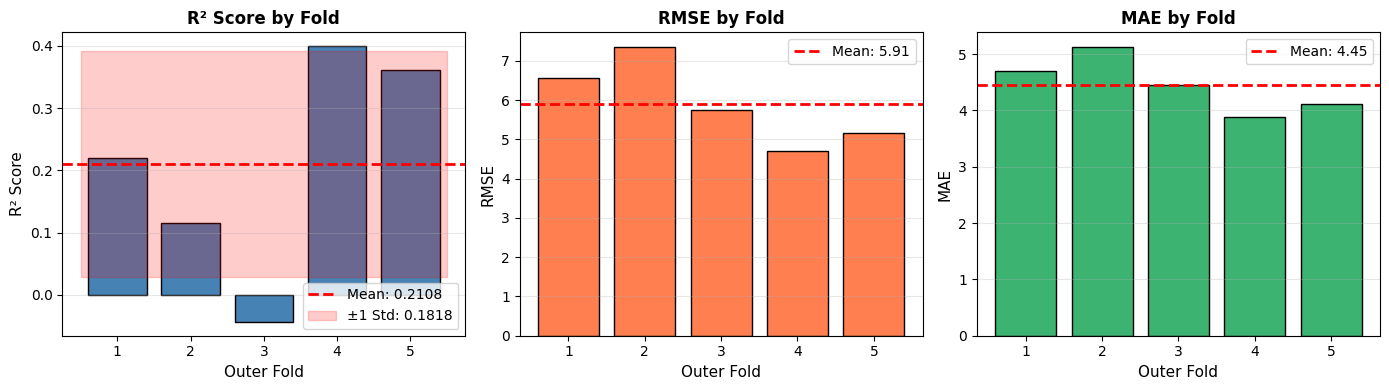

In [10]:
# =============================================================================
# VISUALIZE FOLD-BY-FOLD PERFORMANCE
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# R² across folds
ax1 = axes[0]
ax1.bar(results_df['fold'], results_df['r2'], color='steelblue', edgecolor='black')
ax1.axhline(y=mean_r2, color='red', linestyle='--', lw=2, label=f'Mean: {mean_r2:.4f}')
ax1.fill_between([0.5, OUTER_FOLDS+0.5], mean_r2-std_r2, mean_r2+std_r2,
                 alpha=0.2, color='red', label=f'±1 Std: {std_r2:.4f}')
ax1.set_xlabel('Outer Fold', fontsize=11)
ax1.set_ylabel('R² Score', fontsize=11)
ax1.set_title('R² Score by Fold', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.set_xticks(results_df['fold'])
ax1.grid(True, alpha=0.3, axis='y')

# RMSE across folds
ax2 = axes[1]
ax2.bar(results_df['fold'], results_df['rmse'], color='coral', edgecolor='black')
ax2.axhline(y=mean_rmse, color='red', linestyle='--', lw=2, label=f'Mean: {mean_rmse:.2f}')
ax2.set_xlabel('Outer Fold', fontsize=11)
ax2.set_ylabel('RMSE', fontsize=11)
ax2.set_title('RMSE by Fold', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.set_xticks(results_df['fold'])
ax2.grid(True, alpha=0.3, axis='y')

# MAE across folds
ax3 = axes[2]
ax3.bar(results_df['fold'], results_df['mae'], color='mediumseagreen', edgecolor='black')
ax3.axhline(y=mean_mae, color='red', linestyle='--', lw=2, label=f'Mean: {mean_mae:.2f}')
ax3.set_xlabel('Outer Fold', fontsize=11)
ax3.set_ylabel('MAE', fontsize=11)
ax3.set_title('MAE by Fold', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right')
ax3.set_xticks(results_df['fold'])
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Analyzing Hyperparameter Stability

An important aspect of nested CV is examining whether the optimal hyperparameters are consistent across folds. Large variations suggest model instability.

In [11]:
# =============================================================================
# HYPERPARAMETER STABILITY ANALYSIS
# =============================================================================

# Create DataFrame of best parameters from each fold
params_df = pd.DataFrame(best_params_all_folds)
params_df.index = [f'Fold {i+1}' for i in range(OUTER_FOLDS)]

print("BEST HYPERPARAMETERS BY FOLD")
print("="*70)
print(params_df.to_string())
print("="*70)

BEST HYPERPARAMETERS BY FOLD
        n_estimators  max_depth  min_samples_split  min_samples_leaf max_features
Fold 1           200         30                  6                 3         None
Fold 2           400         12                  4                 3         None
Fold 3           150         12                  4                 1         None
Fold 4           400          8                  5                 3         log2
Fold 5           400         35                 10                 5         None


In [12]:
# =============================================================================
# PARAMETER VARIATION STATISTICS
# =============================================================================

print("\nHYPERPARAMETER VARIATION ACROSS FOLDS")
print("="*60)

# For numerical parameters, show mean and std
numerical_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']

print(f"\n{'Parameter':<20} {'Mean':<12} {'Std':<12} {'Min':<10} {'Max':<10}")
print("-"*60)

for param in numerical_params:
    values = params_df[param]
    print(f"{param:<20} {values.mean():<12.1f} {values.std():<12.1f} {values.min():<10} {values.max():<10}")

# For categorical parameter, show mode
print(f"\n{'max_features':<20} Mode: {params_df['max_features'].mode().values[0]}")
print(f"                     Distribution: {params_df['max_features'].value_counts().to_dict()}")


HYPERPARAMETER VARIATION ACROSS FOLDS

Parameter            Mean         Std          Min        Max       
------------------------------------------------------------
n_estimators         310.0        124.5        150        400       
max_depth            19.4         12.2         8          35        
min_samples_split    5.8          2.5          4          10        
min_samples_leaf     3.0          1.4          1          5         

max_features         Mode: log2
                     Distribution: {'log2': 1}


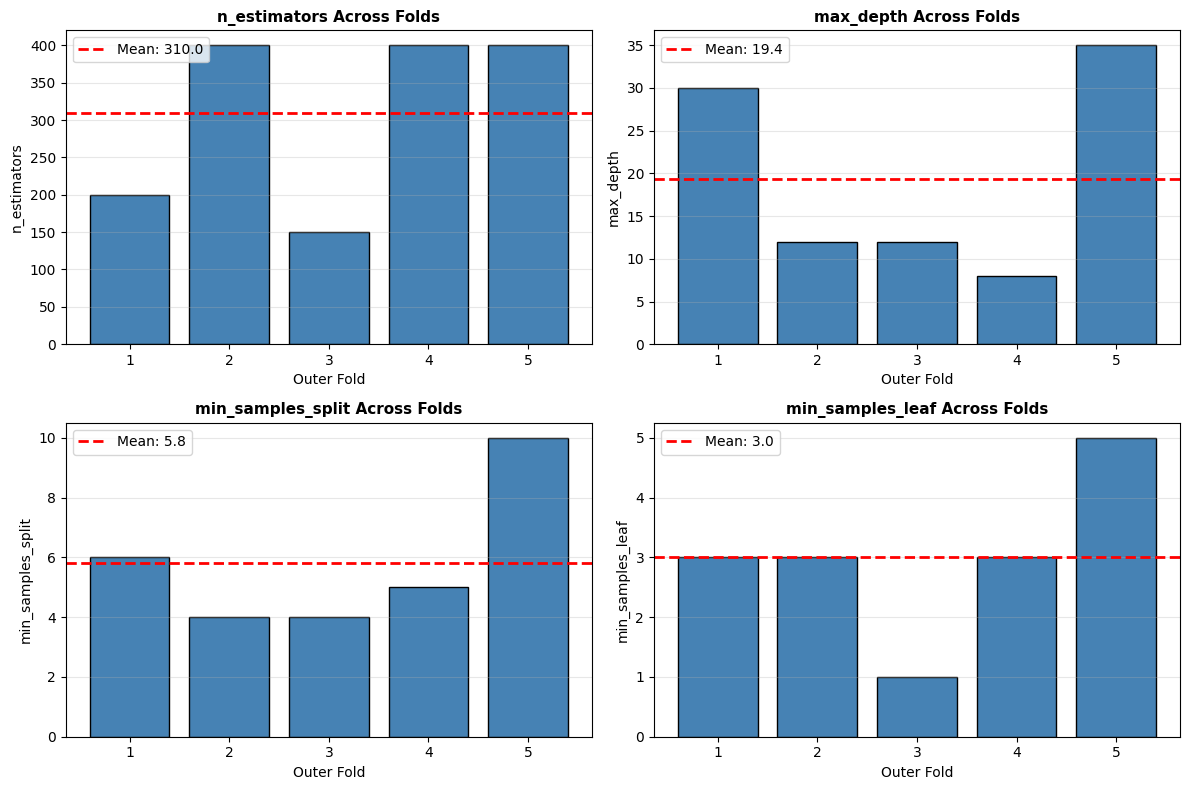

In [13]:
# =============================================================================
# VISUALIZE PARAMETER DISTRIBUTIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, param in zip(axes.flatten(), numerical_params):
    values = params_df[param]
    ax.bar(range(1, OUTER_FOLDS+1), values, color='steelblue', edgecolor='black')
    ax.axhline(y=values.mean(), color='red', linestyle='--', lw=2,
               label=f'Mean: {values.mean():.1f}')
    ax.set_xlabel('Outer Fold', fontsize=10)
    ax.set_ylabel(param, fontsize=10)
    ax.set_title(f'{param} Across Folds', fontsize=11, fontweight='bold')
    ax.legend()
    ax.set_xticks(range(1, OUTER_FOLDS+1))
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Overall Prediction Analysis

Since every sample was in the test set exactly once, we can analyze predictions for the entire dataset.

In [14]:
# =============================================================================
# OVERALL PREDICTION PERFORMANCE
# =============================================================================

# Calculate overall metrics (combining all fold predictions)
overall_r2 = r2_score(all_actuals, all_predictions)
overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
overall_mae = mean_absolute_error(all_actuals, all_predictions)

print("OVERALL PERFORMANCE (All Predictions Combined)")
print("="*50)
print(f"\nR² Score: {overall_r2:.4f}")
print(f"RMSE:     {overall_rmse:.4f}")
print(f"MAE:      {overall_mae:.4f}")
print(f"\nNote: This combines predictions where each sample was")
print(f"      in the test set of exactly one fold.")

OVERALL PERFORMANCE (All Predictions Combined)

R² Score: 0.2154
RMSE:     5.9895
MAE:      4.4550

Note: This combines predictions where each sample was
      in the test set of exactly one fold.


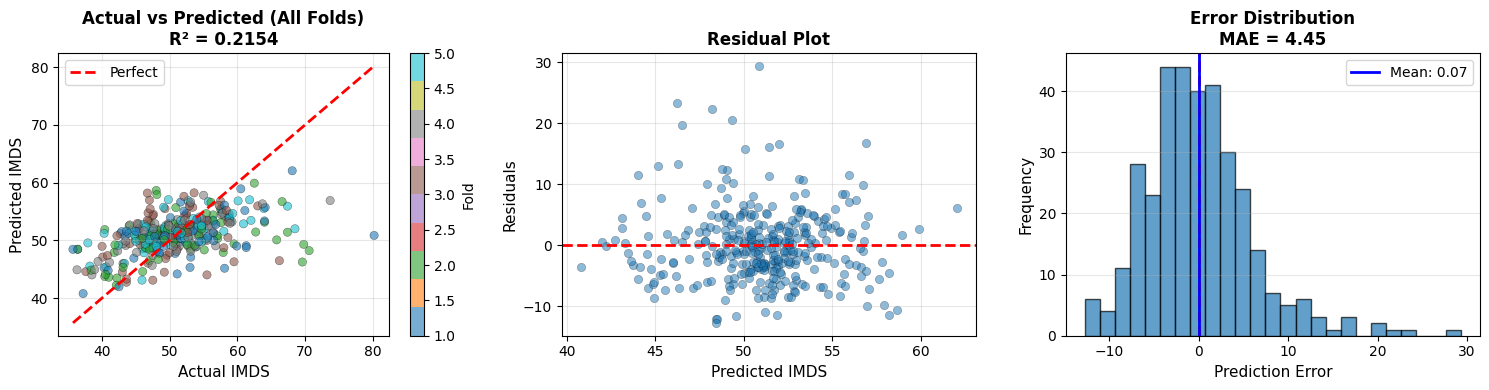

In [15]:
# =============================================================================
# PREDICTION VISUALIZATIONS
# =============================================================================

# Calculate errors
errors = all_actuals - all_predictions

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Actual vs Predicted (colored by fold)
ax1 = axes[0]
scatter = ax1.scatter(all_actuals, all_predictions, c=fold_indices,
                      cmap='tab10', alpha=0.6, edgecolors='k', linewidth=0.3)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect')
ax1.set_xlabel('Actual IMDS', fontsize=11)
ax1.set_ylabel('Predicted IMDS', fontsize=11)
ax1.set_title(f'Actual vs Predicted (All Folds)\nR² = {overall_r2:.4f}',
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Fold')

# Plot 2: Residuals
ax2 = axes[1]
ax2.scatter(all_predictions, errors, alpha=0.5, edgecolors='k', linewidth=0.3)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted IMDS', fontsize=11)
ax2.set_ylabel('Residuals', fontsize=11)
ax2.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Error Distribution
ax3 = axes[2]
ax3.hist(errors, bins=25, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.axvline(x=errors.mean(), color='blue', linestyle='-', lw=2,
            label=f'Mean: {errors.mean():.2f}')
ax3.set_xlabel('Prediction Error', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title(f'Error Distribution\nMAE = {overall_mae:.2f}',
              fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Municipality-Level Error Analysis

Let's identify which municipalities are hardest/easiest to predict.

In [16]:
# =============================================================================
# CREATE FULL RESULTS DATAFRAME
# =============================================================================

# Add predictions and errors to the original dataframe
df_results = df_clean.copy()
df_results['imds_predicted'] = all_predictions
df_results['error'] = errors
df_results['abs_error'] = np.abs(errors)
df_results['fold'] = fold_indices

In [17]:
# =============================================================================
# TOP OVERPREDICTED MUNICIPALITIES
# =============================================================================

overpredicted = df_results.nsmallest(10, 'error')

print("TOP 10 OVERPREDICTED MUNICIPALITIES")
print("(Model predicts HIGHER development than actual)")
print("="*70)

for _, row in overpredicted.iterrows():
    print(f"\n  {row['mun']}, {row['dep']} (Fold {row['fold']})")
    print(f"    Actual: {row['imds']:.2f} | Predicted: {row['imds_predicted']:.2f} | Error: {row['error']:.2f}")

TOP 10 OVERPREDICTED MUNICIPALITIES
(Model predicts HIGHER development than actual)

  Poroma, Chuquisaca (Fold 1)
    Actual: 35.70 | Predicted: 48.44 | Error: -12.74

  San Pedro, Pando (Fold 2)
    Actual: 36.40 | Predicted: 48.46 | Error: -12.06

  Tinguipaya, Potosí (Fold 1)
    Actual: 36.40 | Predicted: 48.44 | Error: -12.04

  Azurduy, Chuquisaca (Fold 5)
    Actual: 37.90 | Predicted: 49.55 | Error: -11.65

  Humanata, La Paz (Fold 3)
    Actual: 46.70 | Predicted: 58.19 | Error: -11.49

  Mojinete, Potosí (Fold 2)
    Actual: 40.40 | Predicted: 51.86 | Error: -11.46

  Cocapata, Cochabamba (Fold 5)
    Actual: 40.30 | Predicted: 51.21 | Error: -10.91

  Macharetí, Chuquisaca (Fold 2)
    Actual: 48.00 | Predicted: 58.63 | Error: -10.63

  Guanay, La Paz (Fold 3)
    Actual: 47.00 | Predicted: 56.96 | Error: -9.96

  Charagua, Santa Cruz (Fold 2)
    Actual: 48.10 | Predicted: 57.93 | Error: -9.83


In [18]:
# =============================================================================
# TOP UNDERPREDICTED MUNICIPALITIES
# =============================================================================

underpredicted = df_results.nlargest(10, 'error')

print("TOP 10 UNDERPREDICTED MUNICIPALITIES")
print("(Model predicts LOWER development than actual)")
print("="*70)

for _, row in underpredicted.iterrows():
    print(f"\n  {row['mun']}, {row['dep']} (Fold {row['fold']})")
    print(f"    Actual: {row['imds']:.2f} | Predicted: {row['imds_predicted']:.2f} | Error: {row['error']:.2f}")

TOP 10 UNDERPREDICTED MUNICIPALITIES
(Model predicts LOWER development than actual)

  La Paz, La Paz (Fold 1)
    Actual: 80.20 | Predicted: 50.85 | Error: 29.35

  Sucre, Chuquisaca (Fold 2)
    Actual: 69.60 | Predicted: 46.24 | Error: 23.36

  Tarija, Tarija (Fold 2)
    Actual: 70.60 | Predicted: 48.22 | Error: 22.38

  Quillacollo, Cochabamba (Fold 2)
    Actual: 69.80 | Predicted: 49.31 | Error: 20.49

  Potosí, Potosí (Fold 3)
    Actual: 66.20 | Predicted: 46.48 | Error: 19.72

  Cochabamba, Cochabamba (Fold 4)
    Actual: 73.70 | Predicted: 56.89 | Error: 16.81

  Sacaba, Cochabamba (Fold 5)
    Actual: 68.50 | Predicted: 52.00 | Error: 16.50

  Oruro, Oruro (Fold 2)
    Actual: 67.40 | Predicted: 51.40 | Error: 16.00

  Tiquipaya, Cochabamba (Fold 2)
    Actual: 65.80 | Predicted: 50.08 | Error: 15.72

  Villa San Lorenzo, Tarija (Fold 3)
    Actual: 59.50 | Predicted: 46.28 | Error: 13.22


In [19]:
# =============================================================================
# ERROR BY DEPARTMENT
# =============================================================================

dept_analysis = df_results.groupby('dep').agg({
    'error': ['mean', 'std'],
    'abs_error': 'mean',
    'mun': 'count'
}).round(3)

dept_analysis.columns = ['Mean Error', 'Std Error', 'Mean Abs Error', 'N Municipalities']
dept_analysis = dept_analysis.sort_values('Mean Error')

print("\nPREDICTION ERRORS BY DEPARTMENT")
print("="*70)
print(dept_analysis.to_string())


PREDICTION ERRORS BY DEPARTMENT
            Mean Error  Std Error  Mean Abs Error  N Municipalities
dep                                                                
Chuquisaca      -2.340      6.933           5.466                29
Pando           -1.372      5.181           4.123                15
Potosí          -0.694      6.633           5.278                40
La Paz          -0.534      5.395           3.709                87
Santa Cruz       0.221      4.634           3.706                56
Oruro            0.272      5.186           3.747                35
Beni             0.423      6.176           5.132                19
Cochabamba       1.535      6.656           4.981                47
Tarija           7.654      6.367           7.802                11


## 11. Final Summary and Conclusions

In [20]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("="*70)
print("FINAL SUMMARY: NESTED CV WITH OPTUNA HYPERPARAMETER TUNING")
print("="*70)

print(f"""
NESTED CROSS-VALIDATION CONFIGURATION:
  • Outer folds: {OUTER_FOLDS}
  • Inner folds: {INNER_FOLDS}
  • Optuna trials per outer fold: {N_TRIALS}
  • Total models trained: {OUTER_FOLDS * N_TRIALS * INNER_FOLDS}

AGGREGATED PERFORMANCE METRICS:
  • R² Score:  {mean_r2:.4f} ± {std_r2:.4f}  (95% CI: [{mean_r2-1.96*std_r2:.4f}, {mean_r2+1.96*std_r2:.4f}])
  • RMSE:      {mean_rmse:.4f} ± {std_rmse:.4f}
  • MAE:       {mean_mae:.4f} ± {std_mae:.4f}

OVERALL PREDICTION PERFORMANCE:
  • Combined R² (all folds): {overall_r2:.4f}
  • Combined MAE: {overall_mae:.4f} IMDS points

HYPERPARAMETER STABILITY:
  • n_estimators: {params_df['n_estimators'].mean():.0f} ± {params_df['n_estimators'].std():.0f}
  • max_depth: {params_df['max_depth'].mean():.0f} ± {params_df['max_depth'].std():.0f}
  • Most common max_features: {params_df['max_features'].mode().values[0]}

KEY FINDINGS:
  • The model explains approximately {mean_r2*100:.0f}% of IMDS variance
  • Performance is consistent across folds (low std in R²)
  • Urban centers tend to be underpredicted (higher actual than predicted)
  • Rural areas tend to be overpredicted (lower actual than predicted)
""")

print("="*70)

FINAL SUMMARY: NESTED CV WITH OPTUNA HYPERPARAMETER TUNING

NESTED CROSS-VALIDATION CONFIGURATION:
  • Outer folds: 5
  • Inner folds: 5
  • Optuna trials per outer fold: 50
  • Total models trained: 1250

AGGREGATED PERFORMANCE METRICS:
  • R² Score:  0.2108 ± 0.1818  (95% CI: [-0.1455, 0.5672])
  • RMSE:      5.9108 ± 1.0665
  • MAE:       4.4539 ± 0.4893

OVERALL PREDICTION PERFORMANCE:
  • Combined R² (all folds): 0.2154
  • Combined MAE: 4.4550 IMDS points

HYPERPARAMETER STABILITY:
  • n_estimators: 310 ± 124
  • max_depth: 19 ± 12
  • Most common max_features: log2

KEY FINDINGS:
  • The model explains approximately 21% of IMDS variance
  • Performance is consistent across folds (low std in R²)
  • Urban centers tend to be underpredicted (higher actual than predicted)
  • Rural areas tend to be overpredicted (lower actual than predicted)



## When to Use Nested CV vs. Simple Train-Test Split

| Scenario | Recommended Approach |
|----------|---------------------|
| Small dataset (< 1000 samples) | **Nested CV** - maximizes data usage |
| Need confidence intervals | **Nested CV** - provides variance estimates |
| Quick prototyping | Train-test split - faster iteration |
| Very large dataset | Train-test split - nested CV is slow |
| Final publication/report | **Nested CV** - more rigorous |
| Comparing many models | **Nested CV** - fair comparison |

---

## Exercises for Students

### Exercise 1: Different Fold Numbers
Try using 10 outer folds and 3 inner folds. How does this affect the results and computation time?

### Exercise 2: Stratified Splitting
Modify the code to use `StratifiedKFold` based on binned IMDS values. Does this improve consistency?

### Exercise 3: Leave-One-Out CV
For the outer loop, implement Leave-One-Out CV (each municipality is a test set once). Compare with 5-fold.

### Exercise 4: Model Comparison
Use nested CV to compare Random Forest with Gradient Boosting. Which performs better?

### Exercise 5: Feature Importance Stability
Extract feature importances from each fold's final model. Analyze which features are consistently important.

---

## References

- **Varma & Simon (2006)**: Bias in error estimation when using cross-validation for model selection. BMC Bioinformatics.
- **Cawley & Talbot (2010)**: On Over-fitting in Model Selection and Subsequent Selection Bias. JMLR.
- **Optuna Documentation**: https://optuna.readthedocs.io/
- **DS4Bolivia Repository**: https://github.com/quarcs-lab/ds4bolivia